# Classifying Caltech-101 using ResNet50

The goal of this notebook is to train a ResNet50 model from scratch on the Caltech-101 dataset using the Keras framework.  If you go [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), you will find a description of the data and a link where you can download it (if you do, also extract it).  You can read the paper on ResNets [here](https://arxiv.org/pdf/1512.03385.pdf); we will be implementing the 50-layer varient as outlined by the authors.  Keras documentation can be found [here](https://keras.io/).  Let's begin!

In [1]:
import os
import numpy as np

from keras.utils import to_categorical
from keras.layers import (
    Input,
    Add,
    Dense,
    Activation,
    ZeroPadding2D,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D
)
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Setting training parameters

We will start by setting a few parameters.  You will need to edit **base_path** to the location of the extracted dataset.

 - **base_path**: Path where the downloaded and extracted dataset is located.
 - **split**: Proportion of data to go into the training set (with the rest used for validation).
 - **num_classes**: Number of classes; 101 in this case.
 - **l2_reg**: Parameter to be used for L2-regularization.
 - **num_epochs**: Number of epochs to use for training.
 - **minibatch_size**: Batch size used for training.
 - **val_batch_size**: Size of batches used in validation (used for generator).

In [2]:
base_path = "/Users/alex/Downloads/"
split = .8

num_classes = 101
l2_reg = .001

num_epochs = 80
minibatch_size = 64
val_batch_size = 56

## Split data into training and validation

We will be taking advantage of generators to avoid loading our data into memory.  Because of this, we need to split our images into training and validation sets on the hard disk.  Below is a script that will create a folder called 
*caltech_data* in the same directory as the downloaded dataset.  Inside *caltech_data* will be two folders, *train* and *val*.  Both of these will have 101 folders corresponding to our data's classes, and these folders will contain our images.

Some classes have fewer than 35 images, so we want to avoid sitations where only a couple images from a class end up in validation or fewer than 25 images from a class end up in training.  To do this, we will ensure that **np.round(N * split)** images from each class are sorted into training, where N is the total number of images in the class that is being sorted.

Not every class has the same number of images, however the imbalance is not great enough to necessitate a correction via over- and undersampling.

In [3]:
raw_path = base_path + "101_ObjectCategories/"
train_path = base_path + "caltech_data/train/"
val_path = base_path + "caltech_data/val/"

In [4]:
os.chdir(base_path)
!mkdir -p caltech_data/train
!mkdir -p caltech_data/val
os.chdir(raw_path)
for directory in os.listdir(raw_path):
    if directory == ".DS_Store" or directory == "BACKGROUND_Google":
        continue
    image_files = os.listdir(raw_path + directory + "/")
    num_images_cat = len(image_files)
    image_files = np.random.permutation(image_files)
    num_train_cat = int(np.round(split * num_images_cat))
    num_val_cat = num_images_cat - num_train_cat
    !mkdir ../caltech_data/train/{directory}
    !mkdir ../caltech_data/val/{directory}
    for i in range(num_train_cat):
        origin_path = raw_path + directory + "/" + image_files[i]
        destination_path = train_path + directory + "/" + image_files[i]
        !cp {origin_path} {destination_path}
    for i in range(num_val_cat):
        origin_path = raw_path + directory + "/" + image_files[num_train_cat + i]
        destination_path = val_path + directory + "/" + image_files[num_train_cat + i]
        !cp {origin_path} {destination_path}

## Define the model architecture

The next three cells will define the ResNet50 architecture.  The first two will define our residual building blocks, and the third will put it all together.

### Architecture, part 1: identity block

The identity block is the basic building block of our residual network.  Also called a bottleneck block, it has three convolution steps with filter sizes 1x1, 3x3, and 1x1, and has batch normalization and ReLU activation following each convolution.  Finally, a short circuit connection adds the input of the block to the output of the third convolution after it has been normalized but before activation.  This short circuit connection is present in every residual block and enables the model to learn faster than a plain network would.

In [5]:
def id_block(X, filters, block_num):
    X_cut = X
    
    X = Conv2D(filters[0], [1, 1], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(l2_reg),
               name = "conv_" + str(block_num) + "_1")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_1")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[0], [3, 3], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(l2_reg),
               name = "conv_" + str(block_num) + "_2")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_2")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[1], [1, 1], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(l2_reg),
               name = "conv_" + str(block_num) + "_3")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_3")(X)

    X = Add()([X, X_cut])
    X = Activation("relu")(X)
    
    return X

### Architecture, part 2: convolution block

The convolution block is used to shrink the length and width dimentions while elongating the depth dimension of our activations.  The structure is similar to the identity block with a few key changes.  First, notice that the initial convolution layer allows us to use a stride other than one (in this model we will always use a stride of two).  This is called downsampling and it scales down the length and width dimensions of our activation by a factor of the stride.
As seen in the next cell, the number of convolution filters used for this block is always double that of the prior one.  Therefore, if the input to this block is of size LxWxD, then the output of the third convolution will be of size (L/2)x(W/2)x(D\*2).  Since the dimensions of the input no longer match those of our output (which was not the case for the identity block), we convolve the input using the same stride as the intial convolution layer and use a number of filters equal to the desired depth dimension.

In [6]:
def conv_block(X, filters, s, block_num):
    X_cut = X
    
    X = Conv2D(filters[0], [1, 1], strides = [s, s], padding = "same",
               kernel_regularizer = l2(l2_reg),
               name = "conv_" + str(block_num) + "_1")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_1")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[0], [3, 3], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(l2_reg),
               name = "conv_" + str(block_num) + "_2")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_2")(X)
    X = Activation("relu")(X)
    
    X = Conv2D(filters[1], [1, 1], strides = [1, 1], padding = "same",
               kernel_regularizer = l2(l2_reg),
               name = "conv_" + str(block_num) + "_3")(X)
    X = BatchNormalization(name = "bn_" + str(block_num) + "_3")(X)
    
    X_cut = Conv2D(filters[1], [1, 1], strides = [s, s], padding = "same",
                   kernel_regularizer = l2(l2_reg),
                   name = "conv_" + str(block_num) + "_cut")(X_cut)
    X_cut = BatchNormalization(name = "bn_" + str(block_num) + "_cut")(X_cut)
    
    X = Add()([X, X_cut])
    X = Activation("relu")(X)
    
    return X

### Architecture, part 3: building the model

We build our model by stacking residual blocks on top of one another.  Before the first residual block we use a 7x7 convolution layer with maxpooling, and then we end with global average pooling feeding into a softmax layer.

In [7]:
def ResNet50(input_shape, num_classes):
    X_input = Input(input_shape)
    
    # Phase 1
    X = Conv2D(64, [7, 7], strides = [2, 2], padding = "same",
               kernel_regularizer = l2(l2_reg),
               name = "conv_1")(X_input)
    X = BatchNormalization(name = "bn_1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D([3, 3], strides=[2, 2], padding = "same")(X)
    
    # Phase 2
    X = conv_block(X, [64, 256], s = 2, block_num = 2)
    X = id_block(X, [64, 256], block_num = 3)
    X = id_block(X, [64, 256], block_num = 4)
    
    # Phase 3
    X = conv_block(X, [128, 512], s = 2, block_num = 5)
    X = id_block(X, [128, 512], block_num = 6)
    X = id_block(X, [128, 512], block_num = 7)
    X = id_block(X, [128, 512], block_num = 8)
    
    # Phase 4
    X = conv_block(X, [256, 1024], s = 2, block_num = 9)
    X = id_block(X, [256, 1024], block_num = 10)
    X = id_block(X, [256, 1024], block_num = 11)
    X = id_block(X, [256, 1024], block_num = 12)
    X = id_block(X, [256, 1024], block_num = 13)
    X = id_block(X, [256, 1024], block_num = 14)
    
    # Phase 5
    X = conv_block(X, [512, 2048], s = 2, block_num = 15)
    X = id_block(X, [512, 2048], block_num = 16)
    X = id_block(X, [512, 2048], block_num = 17)
    
    # Pool and softmax
    X = GlobalAveragePooling2D()(X)
    X = Dense(num_classes, activation = "softmax", name = "softmax")(X)
    
    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

## Initialize our model

The input size of each image is 224x224 pixels with 3 channels (RGB).

In [8]:
resnet50_model = ResNet50(input_shape = (224, 224, 3), num_classes = num_classes)

## Define a learning rate schedule

Rather than use a constant learning rate, we want to decay the learning rate each epoch.  We define a learning rate schedule using an initial value of 4e-4 and subtract 5e-6 every epoch.

In [9]:
def learn_schedule(epoch):
    init_learning_rate = 4e-4
    decay = (80 - epoch) / 80.
    learning_rate = init_learning_rate * decay
    if learning_rate <= 0:
        learning_rate = 5e-6
    return learning_rate

## Initialize LearningRateScheduler

The **learn_scheduler** object will be passed to our training function, and Keras will update the learning rate per the schedule we defined automatically.

In [10]:
learn_scheduler = LearningRateScheduler(learn_schedule)

## Compile our model

We tell Keras that we want to use the adam optimizer, that we want to optimize the [cross entropy loss function](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression), and that our evaluation metric is accuracy.

In [11]:
adam = Adam(lr = learn_schedule(0))
resnet50_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Mean centering

We want to center each image around the average value for each color channel (red, green, and blue).  This function will be passed to our data generators below.  Note that I've cheated a bit and already know the average RGB values from prior tinkering.

In [12]:
rgb_mean = [138.95, 132.34, 124.39]
def center_image(image):    
    image[:,:,0] -= rgb_mean[0]
    image[:,:,1] -= rgb_mean[1]
    image[:,:,2] -= rgb_mean[2]
    return image

## Initialize data generators

As mentioned above, we want to avoid reading our entire dataset into memory so we will use Keras' ImageDataGenerators.  We define two, one for training and one for validation.  For our training generator, we will employ image augmentation that will hopefully allow our model to generalize better to images it hasn't trained on.  For both training and validation, we use our mean centering function and also scale pixel values, which range from 0 to 255, by a factor of (1/255).

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function = center_image,
    rescale = 1./255)

val_datagen = ImageDataGenerator(
    preprocessing_function = center_image,
    rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = minibatch_size)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = val_batch_size,
    shuffle = False)

Found 6941 images belonging to 101 classes.
Found 1736 images belonging to 101 classes.


## Train the model

Keras will train the model for the specified number of epochs.  We need to tell it how many steps are in each epoch for training and validation and pass in our learning rate scheduler.

In [14]:
history = resnet50_model.fit_generator(
    train_generator,
    steps_per_epoch = int(np.ceil(train_generator.n / minibatch_size)),
    epochs = num_epochs,
    validation_data = val_generator,
    validation_steps = val_generator.n // val_batch_size,
    callbacks = [learn_scheduler])

Epoch 1/80
109/109 [==============================] - 1492s 14s/step - loss: 21.3446 - acc: 0.1946 - val_loss: 24.0894 - val_acc: 0.1486
Epoch 2/80
109/109 [==============================] - 1476s 14s/step - loss: 17.9195 - acc: 0.2747 - val_loss: 18.5271 - val_acc: 0.1884
Epoch 3/80
109/109 [==============================] - 1473s 14s/step - loss: 15.2909 - acc: 0.2843 - val_loss: 25.4266 - val_acc: 0.0922
Epoch 4/80
109/109 [==============================] - 1472s 14s/step - loss: 13.6407 - acc: 0.2762 - val_loss: 24.6322 - val_acc: 0.0121
Epoch 5/80
109/109 [==============================] - 1468s 13s/step - loss: 12.3986 - acc: 0.2709 - val_loss: 14.5380 - val_acc: 0.1077
Epoch 6/80
109/109 [==============================] - 1474s 14s/step - loss: 11.2461 - acc: 0.2929 - val_loss: 11.0053 - val_acc: 0.2851
Epoch 7/80
109/109 [==============================] - 1472s 14s/step - loss: 10.1953 - acc: 0.3250 - val_loss: 10.0186 - val_acc: 0.2604
Epoch 8/80
109/109 [=====================

## Plot loss, training accuracy, and validation accuracy

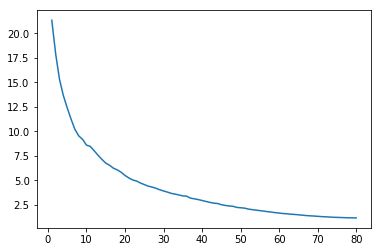

In [15]:
plt.plot(list(range(1, num_epochs+1)), history.history["loss"])

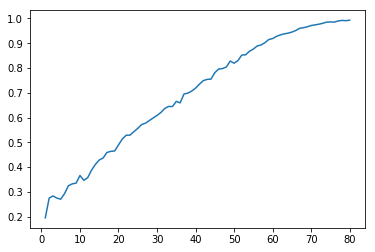

In [16]:
plt.plot(list(range(1, num_epochs+1)), history.history["acc"])

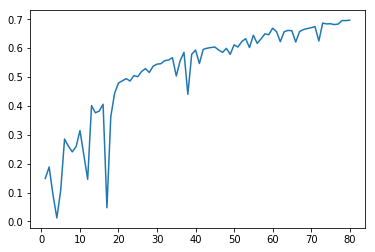

In [17]:
plt.plot(list(range(1, num_epochs+1)), history.history["val_acc"])

## Evaluate accuracy (top-1 accuracy)

In [18]:
val_predictions_probs = resnet50_model.predict_generator(val_generator)
val_predictions_class = val_predictions_probs.argmax(axis=-1)
val_truth = val_generator.classes
num_correct = np.zeros(num_classes)
num_class = np.zeros(num_classes)
for i in range(val_generator.n):
    truth = val_truth[i]
    pred = val_predictions_class[i]
    num_class[truth] += 1
    if pred == truth:
        num_correct[pred] += 1

acc_per_class = [num_correct[i]/num_class[i] for i in range(num_classes)]

In [19]:
print("Overall accuracy: " + str(np.sum(num_correct) / val_generator.n))
print("Average accuracy per class: " + str(np.mean(acc_per_class)))

Overall accuracy: 0.6964285714285714
Average accuracy per class: 0.5507699582975027


## Evaluate top-5 accuracy

In [20]:
val_predictions_top5 = []
for i in range(val_generator.n):
    preds = np.vstack((np.arange(num_classes), val_predictions_probs[i,:]))
    top5 = set(preds[:, preds[1,:].argsort()][0, -5:])
    val_predictions_top5.append(top5)
    
num_correct_top5 = np.zeros(num_classes)
num_class_top5 = np.zeros(num_classes)
for i in range(val_generator.n):
    truth = val_truth[i]
    pred_top5 = val_predictions_top5[i]
    num_class_top5[truth] += 1
    if truth in pred_top5:
        num_correct_top5[truth] += 1

acc_per_class_top5 = [num_correct_top5[i]/num_class_top5[i] for i in range(num_classes)]

In [21]:
print("Overall accuracy: " + str(np.sum(num_correct_top5) / val_generator.n))
print("Average accuracy per class: " + str(np.mean(acc_per_class_top5)))

Overall accuracy: 0.8519585253456221
Average accuracy per class: 0.7709148855359382


## Final thoughts

We can see that overall accuracy lags behind the average accuracy per class.  Below, we examine the classwise top-1 accuracy alongside the number of validation images in that class sorted from most images to least.  The top six classes account for a third of the total number of validation images, and the accuracy on these classes is very high.  This is unsurprising, as the classes with the most validation images have the most data to train on (training images).

In [22]:
table_out = np.vstack((acc_per_class, num_class)).transpose()
table_out = table_out[table_out[:,1].argsort()]
np.set_printoptions(suppress = True)
print("\033[1m" + "    Accuracy   Images per class" + "\033[0m")
print(np.flip(table_out, axis = 0))

    Accuracy   Images per class
[[  0.9875     160.        ]
 [  0.975      160.        ]
 [  0.98850575  87.        ]
 [  0.96551724  87.        ]
 [  0.91666667  48.        ]
 [  1.          40.        ]
 [  0.65384615  26.        ]
 [  1.          25.        ]
 [  0.73913043  23.        ]
 [  0.9047619   21.        ]
 [  0.6         20.        ]
 [  0.8         20.        ]
 [  0.55        20.        ]
 [  0.44444444  18.        ]
 [  0.55555556  18.        ]
 [  0.47058824  17.        ]
 [  0.47058824  17.        ]
 [  0.47058824  17.        ]
 [  0.82352941  17.        ]
 [  0.47058824  17.        ]
 [  0.64705882  17.        ]
 [  0.52941176  17.        ]
 [  0.88235294  17.        ]
 [  0.5625      16.        ]
 [  0.9375      16.        ]
 [  0.5         16.        ]
 [  0.75        16.        ]
 [  0.33333333  15.        ]
 [  0.6         15.        ]
 [  0.93333333  15.        ]
 [  0.2         15.        ]
 [  0.28571429  14.        ]
 [  0.5         14.        ]
 [  0.57142